In [1]:
%matplotlib inline

In [2]:
import datetime
import itertools
import json
import logging
import requests
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

logger = logging.getLogger('notebook')
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stderr)
logger.handlers = [handler]

### Setting dates of analysis: 01 sep 2017 - 13 oct 2017

In [3]:
start_date = datetime.date(2017,9,1)
end_date = datetime.date(2017,10,13)

dates = [start_date + datetime.timedelta(days=i) for i in range((end_date-start_date).days)] 

### Downloading rides of all trains in the analyzed timeframe

In [47]:
def get_day_data(date):
    date_formatted = date.strftime('%Y-%m-%d')
    logger.info('Downloading data for {0}'.format(date_formatted))
    
    url = 'https://rata.digitraffic.fi/api/v1/trains/{0}'.format(date_formatted)
    logger.info('\tURL: {0}'.format(url))
    
    r = requests.get(url)
    data = json.loads(r.text)
    return data

In [48]:
data_unflattened = [get_day_data(date) for date in dates]
data = list(itertools.chain(*data_unflattened))

	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-01
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-02
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-03
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-04
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-05
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-06
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-07
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-08
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-09
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-10
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-11
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-12
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-13
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-14
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-15
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-16
	URL: https://rata.digitraffic.fi/api/v1/trains/2017-09-

In [49]:
with open('trains_1sep-13oct.json', 'w') as fp:
    json.dump(data, fp)
    
del data

### Downloading compositions of all trains in the analyzed timeframe

In [475]:
def get_configuration_day_data(date):
    date_formatted = date.strftime('%Y-%m-%d')
    logger.info('Downloading data for {0}'.format(date_formatted))
    
    url = 'https://rata.digitraffic.fi/api/v1/compositions/{0}'.format(date_formatted)
    logger.info('\tURL: {0}'.format(url))
    
    r = requests.get(url)
    data = json.loads(r.text)
    return data

In [476]:
data_unflattened = [get_configuration_day_data(date) for date in dates]
data = list(itertools.chain(*data_unflattened))

	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-01
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-02
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-03
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-04
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-05
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-06
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-07
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-08
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-09
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-10
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-11
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-12
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-13
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-14
	URL: https://rata.digitraffic.fi/api/v1/compositions/2017-09-15
	URL: https://rata.digitr

In [477]:
with open('configurations_1sep-13oct.json', 'w') as fp:
    json.dump(data, fp)
    
del data

### Loading train data and metadata (stations, operators, cause-codes)

In [4]:
with open('trains_1sep-13oct.json', 'r') as fp:
    trains_data = pd.DataFrame(json.load(fp))

In [5]:
with open('configurations_1sep-13oct.json', 'r') as fp:
    configurations_data = pd.DataFrame(json.load(fp))

In [6]:
r = requests.get('https://rata.digitraffic.fi/api/v1/metadata/stations')
stations = pd.DataFrame(json.loads(r.text))

In [7]:
r = requests.get('https://rata.digitraffic.fi/api/v1/metadata/operators')
operators = pd.DataFrame(json.loads(r.text))

In [8]:
r = requests.get('https://rata.digitraffic.fi/api/v1/metadata/cause-category-codes')
causes = pd.DataFrame(json.loads(r.text))

causes['categoryNameEng'] = ['Timetable And Traffic', 'Passage Ahead Of Time', 'Staff', 'Other Reasons', 'Formation Of Train',
    'Equipments, Motorways And Wagons', 'Traffic Care', 'Passenger Service', 'Accident', 'Traffic Care Systems',
                             'Railway Work', 'Electric Track', 'Track (Wheel Structure)', 'Tow Vehicles']

### Extracting summary indicators of each train's ride (start and end time of the ride, start and end station of the ride, number of stops during the ride, percent of cancelled stops, average difference between scheduled and actual stop time, list of causes for deviating from the schedule)

In [9]:
del trains_data['runningCurrently'], trains_data['commuterLineID']
del trains_data['cancelled'], trains_data['timetableAcceptanceDate']

trains_data['actualTime_Start'] = trains_data['timeTableRows'].apply(lambda x: x[0]['actualTime']
                                    if ('actualTime' in x[0]) else np.nan)
trains_data['actualTime_End'] = trains_data['timeTableRows'].apply(lambda x: x[-1]['actualTime']
                                    if ('actualTime' in x[-1]) else np.nan)
trains_data['stationCode_Start'] = trains_data['timeTableRows'].apply(lambda x: x[0]['stationUICCode']
                                    if ('stationUICCode' in x[0]) else np.nan)
trains_data['stationCode_End'] = trains_data['timeTableRows'].apply(lambda x: x[-1]['stationUICCode']
                                    if ('stationUICCode' in x[-1]) else np.nan)
trains_data['Total_Stops'] = trains_data['timeTableRows'].apply(lambda x: len(x)/2+1)
trains_data['Cancelled_stops_percent'] = trains_data['timeTableRows'].apply(lambda x: 
                            pd.DataFrame(x)['cancelled'].sum()/len(x) if ('cancelled' in pd.DataFrame(x)) else np.nan)
trains_data['DiffInMinutes_average'] = trains_data['timeTableRows'].apply(lambda x: pd.DataFrame(x)['differenceInMinutes'].mean()
                                    if ('differenceInMinutes' in pd.DataFrame(x)) else np.nan)

In [10]:
def CauseIDs_extract(df_row):
    if (not pd.DataFrame(df_row)['causes'].empty):
        cause_df = pd.DataFrame([item[0] for item in list(filter(None, pd.DataFrame(df_row)['causes']))])
        if ('categoryCodeId' in cause_df):
            return list(set(cause_df['categoryCodeId']))
        else:
            return np.nan
    else:
        return np.nan
    
trains_data['CauseIDs'] = trains_data['timeTableRows'].apply(CauseIDs_extract)

### Looking up names of stations and operators from metadata

In [11]:
del trains_data['timeTableRows']

trains_data = pd.merge(trains_data, operators[['operatorUICCode', 'operatorName']],
                how='left', on=['operatorUICCode'])
del trains_data['operatorShortCode'], trains_data['operatorUICCode']

trains_data = pd.merge(trains_data, stations[['stationUICCode', 'stationName', 'type']]
    .rename(columns={'stationUICCode': 'stationUICCode', 'stationName': 'Start_Station_Name', 'type': 'Start_Station_Type'}),
                    how='left', left_on='stationCode_Start', right_on='stationUICCode')
del trains_data['stationCode_Start'], trains_data['stationUICCode']

trains_data = pd.merge(trains_data, stations[['stationUICCode', 'stationName', 'type']]
    .rename(columns={'stationUICCode': 'stationUICCode', 'stationName': 'End_Station_Name', 'type': 'End_Station_Type'}),
                    how='left', left_on='stationCode_End', right_on='stationUICCode')
del trains_data['stationCode_End'], trains_data['stationUICCode']

### Computing total length of each train's ride (in hours)

In [12]:
def gt(in_str):
    dt_str = str(in_str)
    if (dt_str != "nan"):
        dt, _, us = dt_str.partition(".")
        dt = datetime.datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")
        us = int(us.rstrip("Z"), 10)
        return dt + datetime.timedelta(microseconds=us)
    else:
        return np.nan
    
trains_data['Hours_Operated'] = (trains_data['actualTime_End'].apply(gt) -
        trains_data['actualTime_Start'].apply(gt)).apply(lambda x: x.total_seconds() / 60**2)

### Extracting summary indicators of each train's composition (type of locomotive used, total length of the train, number of railcars)

In [13]:
configurations_data['locomotiveType'] = configurations_data['journeySections'].apply(lambda x:
                                        sorted([item[0]['locomotiveType'] if (len(item) < 2) else '~several locomotives'
                                        for item in pd.DataFrame(x)['locomotives']], reverse = True)[0])
configurations_data['totalLength'] = configurations_data['journeySections'].apply(lambda x: 
                                    max([item['totalLength'] for item in x]))
configurations_data['Number_of_railcars'] = configurations_data['journeySections'].apply(lambda x: 
                                    max([len(item['wagons']) for item in x]))
del configurations_data['journeySections'], configurations_data['operatorShortCode'], configurations_data['operatorUICCode']
del configurations_data['trainCategory'], configurations_data['trainType']

### Looking up causes for deviating from schedule from metadata and collating them with train's ride indicators (percent of cancelled stops, average difference between scheduled and actual stop time)

In [15]:
CausesDF = pd.DataFrame(trains_data['CauseIDs'].apply(pd.Series).stack(dropna=True))
CausesDF = CausesDF.rename(columns = {0: 'CauseCategoryID'})
CausesDF['Index0'] = CausesDF.index.get_level_values(0)

In [16]:
CausesDF = pd.merge(CausesDF, causes[['id', 'categoryNameEng']],
                how='left', left_on=['CauseCategoryID'], right_on=['id'])
del CausesDF['id']

CausesDF = pd.merge(CausesDF, trains_data[['Cancelled_stops_percent', 'DiffInMinutes_average']],
                how='left', left_on=['Index0'], right_index=True)

### Merging train rides and compositions data

In [17]:
Combined_data = pd.merge(trains_data, configurations_data, how='left', on=['departureDate', 'trainNumber'])
Combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68623 entries, 0 to 68622
Data columns (total 22 columns):
departureDate              68623 non-null object
timetableType              68623 non-null object
trainCategory              68623 non-null object
trainNumber                68623 non-null int64
trainType                  68623 non-null object
version_x                  68623 non-null int64
actualTime_Start           60671 non-null object
actualTime_End             60022 non-null object
Total_Stops                68623 non-null float64
Cancelled_stops_percent    68623 non-null float64
DiffInMinutes_average      61459 non-null float64
CauseIDs                   17675 non-null object
operatorName               68623 non-null object
Start_Station_Name         68623 non-null object
Start_Station_Type         68623 non-null object
End_Station_Name           68623 non-null object
End_Station_Type           68623 non-null object
Hours_Operated             59526 non-null float64
version

### Descriptive statistics of data by timetable type (averages except trainNumber)

In [18]:
variables = ['timetableType', 'trainNumber', 'Hours_Operated', 'Number_of_railcars', 'totalLength', 
        'DiffInMinutes_average', 'Cancelled_stops_percent']
Combined_data[variables].groupby(['timetableType']).agg({'trainNumber': 'count', 'Hours_Operated': 'mean', 
        'Number_of_railcars': 'mean', 'totalLength': 'mean', 'DiffInMinutes_average': 'mean', 
        'Cancelled_stops_percent': 'mean'}).reset_index()

,timetableType,trainNumber,Number_of_railcars,DiffInMinutes_average,Cancelled_stops_percent,totalLength,Hours_Operated
0,ADHOC,10577,3.123457,2.936628,0.201081,118.787037,1.816793
1,REGULAR,58046,1.998302,0.612466,0.054957,105.215246,1.460892


### Descriptive statistics of data by train category (averages except trainNumber)

In [19]:
variables = ['trainCategory', 'trainNumber', 'Hours_Operated', 'Number_of_railcars', 'totalLength', 
        'DiffInMinutes_average', 'Cancelled_stops_percent']
Combined_data[variables].groupby(['trainCategory']).agg({'trainNumber': 'count', 'Hours_Operated': 'mean', 
        'Number_of_railcars': 'mean', 'totalLength': 'mean', 'DiffInMinutes_average': 'mean', 
        'Cancelled_stops_percent': 'mean'}).reset_index()

,trainCategory,trainNumber,Number_of_railcars,DiffInMinutes_average,Cancelled_stops_percent,totalLength,Hours_Operated
0,Cargo,13618,NaN,-0.847403,0.228441,NaN,3.340907
1,Commuter,33731,1.423789,0.787810,0.005267,99.182128,0.729096
2,Locomotive,5461,NaN,-1.879164,0.283768,NaN,0.957982
3,Long-distance,9860,4.046417,3.284290,0.020136,126.782139,2.721802
4,On-track machines,1038,NaN,7.039859,0.025151,NaN,1.465650
5,Shunting,4814,NaN,3.303696,0.050893,NaN,0.379577
6,Test drive,101,NaN,-1.583854,0.089109,NaN,2.436812


### Descriptive statistics of data by locomotive type (averages except trainNumber)

In [20]:
variables = ['locomotiveType', 'trainNumber', 'Hours_Operated', 'Number_of_railcars', 'totalLength', 
        'DiffInMinutes_average', 'Cancelled_stops_percent']
Combined_data[variables].groupby(['locomotiveType']).agg({'trainNumber': 'count', 'Hours_Operated': 'mean', 
        'Number_of_railcars': 'mean', 'totalLength': 'mean', 'DiffInMinutes_average': 'mean', 
        'Cancelled_stops_percent': 'mean'}).reset_index()

,locomotiveType,trainNumber,Number_of_railcars,DiffInMinutes_average,Cancelled_stops_percent,totalLength,Hours_Operated
0,Dm12,1545,0.000000,2.017704,0.009047,25.983172,1.319172
1,Dr12,11,8.727273,-1.297586,0.000000,220.272727,2.884495
2,Dr16,3,2.333333,-1.112745,0.000000,79.333333,1.910741
3,Dv12,6,2.666667,6.694872,0.000000,85.000000,0.511991
4,Sm2,2142,1.000000,1.626595,0.002801,53.000000,0.743060
5,Sm3,1192,5.994966,2.328018,0.000061,159.996644,2.917671
6,Sm4,1411,0.998583,0.921331,0.005090,54.011339,0.990810
7,Sm5,18489,0.999892,0.593871,0.006650,75.000000,0.623300
8,Sm6,346,7.000000,2.202095,0.000000,188.000000,3.392225
9,Sr1,1736,4.233871,4.712973,0.001144,132.807028,2.728320


### Histogram of train types

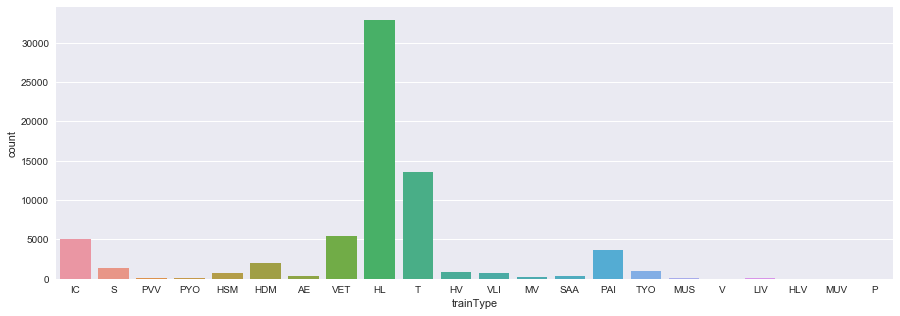

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x="trainType", ax=ax, data=Combined_data)

### Histogram of operators

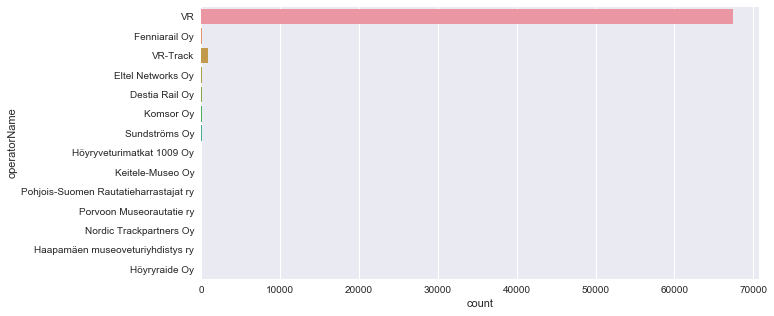

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(y="operatorName", ax=ax, data=Combined_data)

### Histogram of causes for deviating from schedule

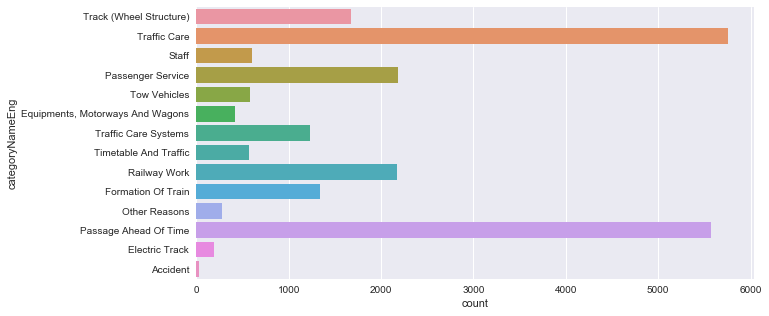

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(y="categoryNameEng", ax=ax, data=CausesDF)

### Interval plot of number of hours operated by a train

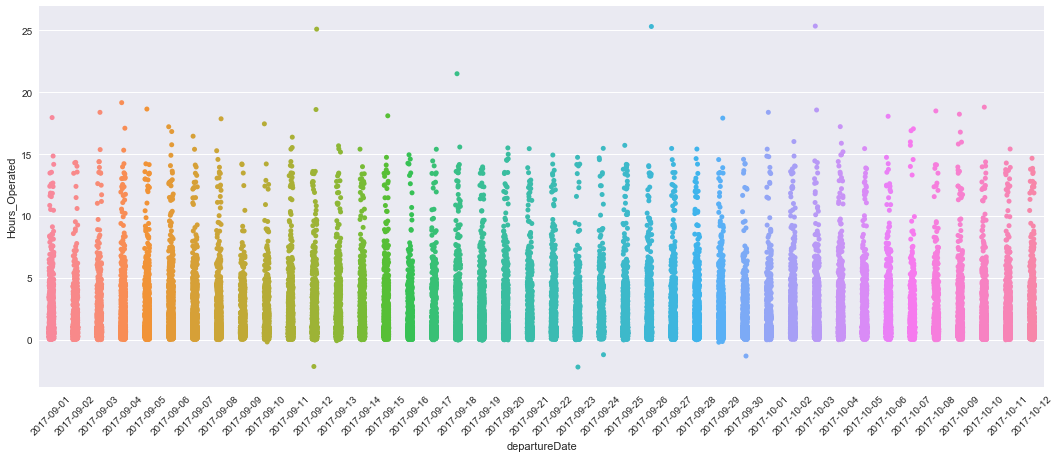

In [24]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.stripplot(x="departureDate", y="Hours_Operated", ax=ax, data=Combined_data, jitter=True)
plt.xticks(rotation=45);

### Interval plot of percent of cancelled stops by a train

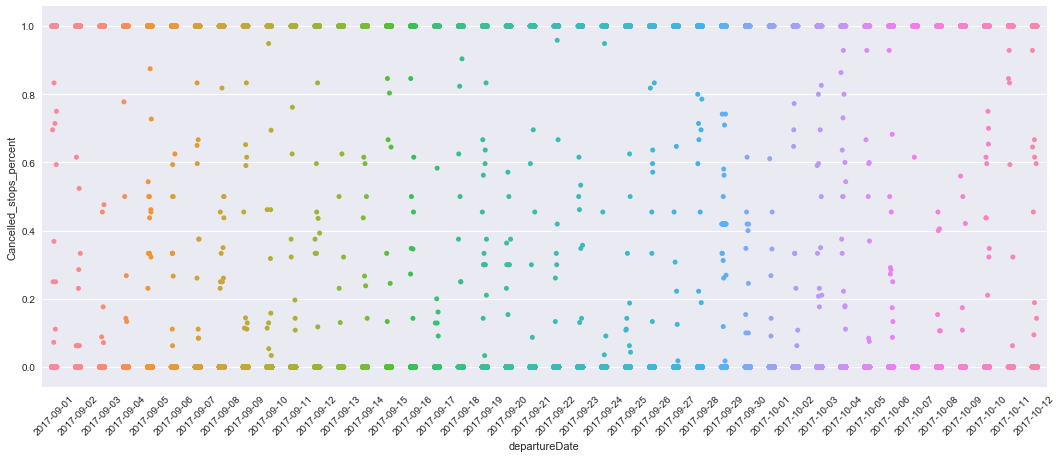

In [25]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.stripplot(x="departureDate", y="Cancelled_stops_percent", ax=ax, data=Combined_data, jitter=True)
plt.xticks(rotation=45);

### Interval plot of average difference between scheduled and actual stop time by a train

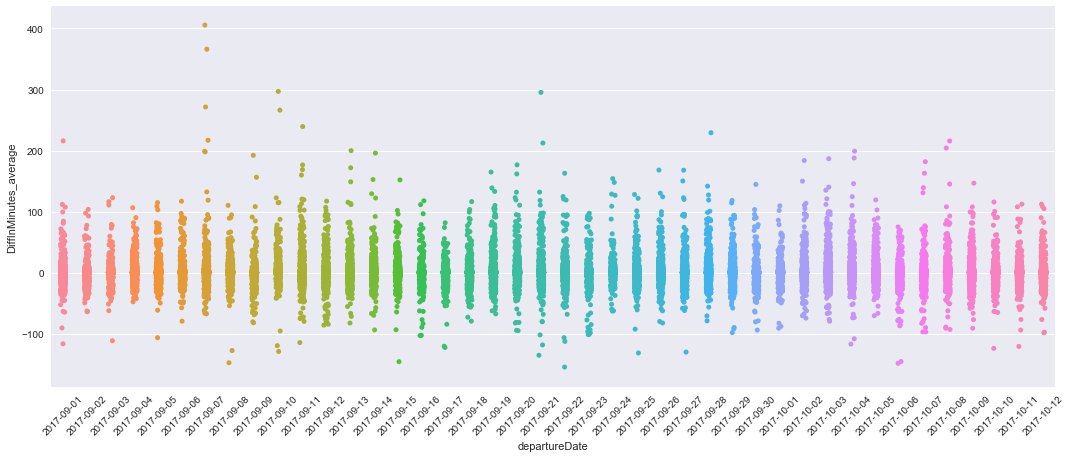

In [26]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.stripplot(x="departureDate", y="DiffInMinutes_average", ax=ax, data=Combined_data, jitter=True)
plt.xticks(rotation=45);

### Collating percent of cancelled stops with causes

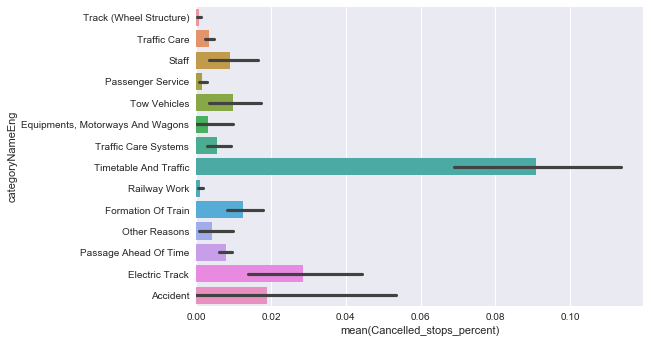

In [27]:
sns.barplot(x="Cancelled_stops_percent", y="categoryNameEng", data=CausesDF);

### Collating average difference between scheduled and actual stop with causes

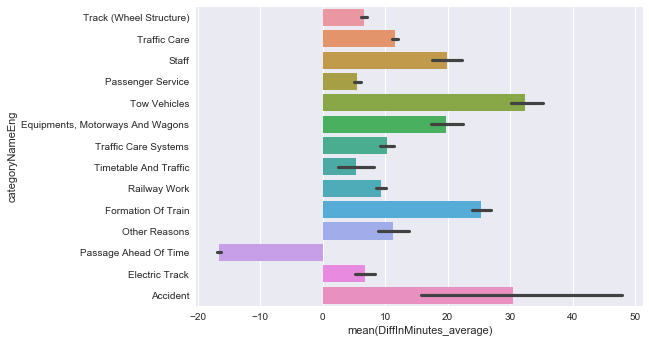

In [28]:
sns.barplot(x="DiffInMinutes_average", y="categoryNameEng", data=CausesDF);

### Relation of percent of cancelled stops to train's total length and number of railcars by timetable type

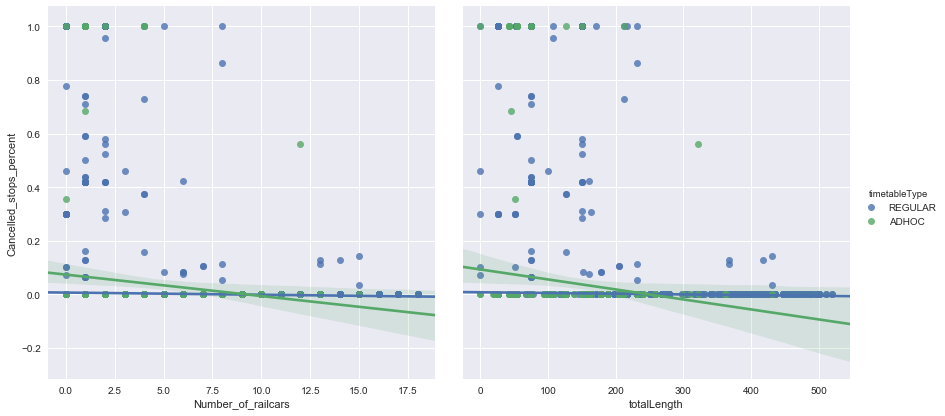

In [29]:
sns.pairplot(x_vars=["Number_of_railcars", "totalLength"], y_vars=["Cancelled_stops_percent"],
             hue='timetableType', kind="reg", data=Combined_data, size = 6)

### Relation of average difference between scheduled and actual stop to train's total length and number of railcars by timetable type

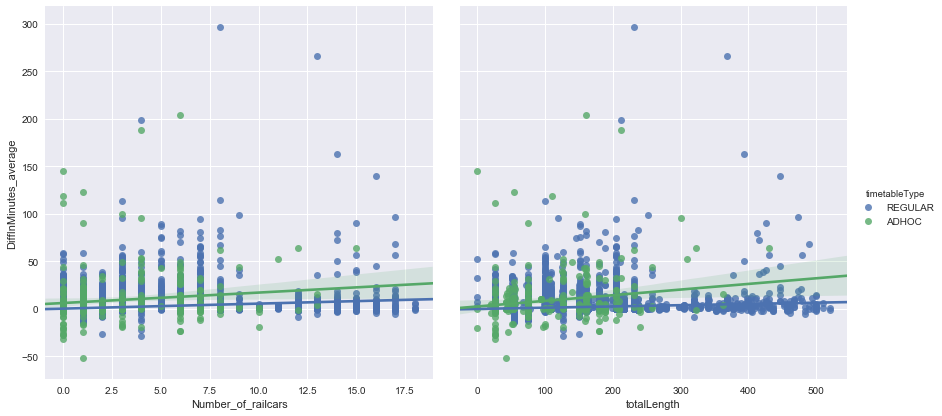

In [30]:
sns.pairplot(x_vars=["Number_of_railcars", "totalLength"], y_vars=["DiffInMinutes_average"],
             hue='timetableType', kind="reg", data=Combined_data, size = 6)

### Estimating a Gradient Boosting model for average difference between scheduled and actual stop with 10-fold crossvalidation and grid search of hyperparameters (test set size - 20%, loss function - MSE)

In [55]:
ML_Data = pd.DataFrame(Combined_data[['Hours_Operated', 'totalLength', 'Number_of_railcars', 'timetableType', 'trainType',
                                      'operatorName', 'Cancelled_stops_percent', 'DiffInMinutes_average']])
ML_Data = ML_Data.dropna(axis=0, how='any')
ML_Data['const'] = np.ones(ML_Data.shape[0])

X = ML_Data[['Hours_Operated', 'totalLength', 'Number_of_railcars']]
X = X.join(pd.get_dummies(ML_Data['timetableType']).iloc[:,1:], how='left')
X = X.join(pd.get_dummies(ML_Data['operatorName']).iloc[:,1:], how='left')
X = X.join(pd.get_dummies(ML_Data['trainType']).iloc[:,1:], how='left')
X = X.join(pd.get_dummies(ML_Data['const']), how='left')
y = ML_Data['DiffInMinutes_average']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
estm = GradientBoostingRegressor()
tuned_parameters = [{'learning_rate': [0.01, 0.1, 1], 'max_depth': [1, 5, 10]}]

clf = GridSearchCV(estimator=estm, param_grid=tuned_parameters, cv=KFold(n_splits=10), scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

print("Grid MSE scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.7f (+/-%0.05f) for %r" % (mean, std * 2, params))
print()
print("Best MSE score is %0.7f." % clf.best_score_, "Best parameters set found on development set:")
print(clf.best_params_)

Grid MSE scores on development set:
-16.0209316 (+/-8.31084) for {'learning_rate': 0.01, 'max_depth': 1}
-15.4601492 (+/-8.74092) for {'learning_rate': 0.01, 'max_depth': 5}
-14.8021761 (+/-8.99418) for {'learning_rate': 0.01, 'max_depth': 10}
-15.1806392 (+/-7.31023) for {'learning_rate': 0.1, 'max_depth': 1}
-16.2844542 (+/-13.32309) for {'learning_rate': 0.1, 'max_depth': 5}
-16.8746182 (+/-11.91227) for {'learning_rate': 0.1, 'max_depth': 10}
-15.2888646 (+/-6.93628) for {'learning_rate': 1, 'max_depth': 1}
-24.1136320 (+/-20.11647) for {'learning_rate': 1, 'max_depth': 5}
-23.4212954 (+/-10.82790) for {'learning_rate': 1, 'max_depth': 10}

Best MSE score is -14.8021761. Best parameters set found on development set:
{'learning_rate': 0.01, 'max_depth': 10}


R2 score of the model is 0.13526.



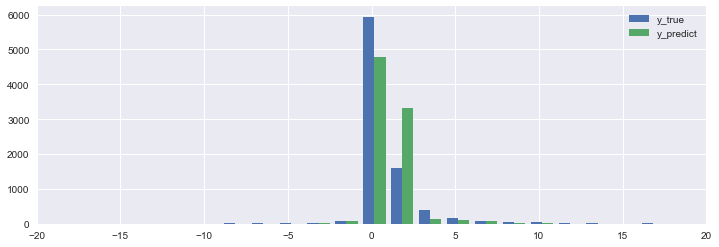

In [57]:
gb_best_params = clf.best_params_
estm.set_params(**gb_best_params)
estm.fit(X_train, y_train)

y_true, y_predict = y_test, estm.predict(X_test)
print("R2 score of the model is %0.5f." % r2_score(y_true = y_true, y_pred = y_predict))
print()

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_xlim([-20, 20])
plt.hist([y_true, y_predict], bins = 100)
plt.legend(labels = ['y_true', 'y_predict'])
plt.show()

### Estimating a Gradient Boosting model for percent of cancelled stops with 10-fold crossvalidation and grid search of hyperparameters (test set size - 20%, loss function - MSE)

In [58]:
ML_Data = ML_Data[ML_Data.Cancelled_stops_percent != 1.0]

X = ML_Data[['Hours_Operated', 'totalLength', 'Number_of_railcars']]
X = X.join(pd.get_dummies(ML_Data['timetableType']).iloc[:,1:], how='left')
X = X.join(pd.get_dummies(ML_Data['operatorName']).iloc[:,1:], how='left')
X = X.join(pd.get_dummies(ML_Data['trainType']).iloc[:,1:], how='left')
X = X.join(pd.get_dummies(ML_Data['const']), how='left')
y = ML_Data['Cancelled_stops_percent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [59]:
estm = GradientBoostingRegressor()
tuned_parameters = [{'learning_rate': [0.001, 0.01, 0.1], 'max_depth': [1, 3, 5]}]

clf = GridSearchCV(estimator=estm, param_grid=tuned_parameters, cv=KFold(n_splits=10), scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

print("Grid MSE scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.7f (+/-%0.05f) for %r" % (mean, std * 2, params))
print()
print("Best MSE score is %0.7f." % clf.best_score_, "Best parameters set found on development set:")
print(clf.best_params_)

Grid MSE scores on development set:
-0.0000117 (+/-0.00006) for {'learning_rate': 0.001, 'max_depth': 1}
-0.0000119 (+/-0.00006) for {'learning_rate': 0.001, 'max_depth': 3}
-0.0000118 (+/-0.00006) for {'learning_rate': 0.001, 'max_depth': 5}
-0.0000117 (+/-0.00006) for {'learning_rate': 0.01, 'max_depth': 1}
-0.0000161 (+/-0.00007) for {'learning_rate': 0.01, 'max_depth': 3}
-0.0000162 (+/-0.00007) for {'learning_rate': 0.01, 'max_depth': 5}
-0.0000117 (+/-0.00006) for {'learning_rate': 0.1, 'max_depth': 1}
-0.0000216 (+/-0.00008) for {'learning_rate': 0.1, 'max_depth': 3}
-0.0000216 (+/-0.00008) for {'learning_rate': 0.1, 'max_depth': 5}

Best MSE score is -0.0000117. Best parameters set found on development set:
{'learning_rate': 0.01, 'max_depth': 1}


In [60]:
gb_best_params = clf.best_params_
estm.set_params(**gb_best_params)
estm.fit(X_train, y_train)

y_true, y_predict = y_test, estm.predict(X_test)
print("R2 score of the model is %0.5f." % r2_score(y_true = y_true, y_pred = y_predict))
print()

R2 score of the model is 0.00000.

